In [1]:
import warnings
warnings.filterwarnings('ignore')

# data imports
import pandas as pd
import numpy as np
from plotnine import *

# modeling imports
from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.preprocessing import StandardScaler,PolynomialFeatures #Z-score variables, Polynomial
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error #model evaluation

# pipeline imports
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
%matplotlib inline

# Review

## Feature Engineering

In order to make better models, sometimes we create new features in our data. This can be as simple as creating a column like `BMI` or `bill_ratio` like we've done in past classworks, or extracting the day of the week from a date string, but it can also be things like creating **polynomial features**, **step functions**, **splines**, or **interactions** like we discussed in the lecture. 

These features can help our model perform better. For  **polynomial features**, **step functions**, and **splines**, it also allows us to add non-linearity to our predictions even though we're using *linear* regression.


- <img src="https://drive.google.com/uc?export=view&id=1o6mI_7aY5A-xTwerptd3v9_GkNs9kG3L" alt="Q" width = "400"/>


- <img src="https://drive.google.com/uc?export=view&id=1pSDedwmNzfsezIOVKj36Fp4KtmCsNOTR" alt="Q" width = "400"/>


- <img src="https://drive.google.com/uc?export=view&id=1KxmPMBZ5ZlyB8WsEPicUKGIIU17oxSBA" alt="Q" width = "400"/>






# `sklearn`
Let's build a polynomial regression in sklearn. First, let's look at what `PolynomialFeatures()` is doing under the hood.

In [2]:
np.random.seed(8675309)

x = pd.DataFrame({"x" : np.random.normal(size = 100),
                  "y" : np.random.normal(size = 100),
                  "z" : np.random.normal(size = 100)
                  })

x.head()

,x,y,z
0,0.589024,0.144687,-2.560439
1,0.733119,-0.846574,0.961272
2,-1.162189,-1.120992,0.743904
3,-0.556816,-0.388865,-0.470965
4,-0.772488,-0.335495,-1.003179


In [3]:
p = PolynomialFeatures(degree = 3, include_bias= False)

x_new = pd.DataFrame(p.fit_transform(x))
x_new.columns = p.get_feature_names_out(x.columns)
x_new.head()

,x,y,z,x^2,x y,x z,y^2,y z,z^2,x^3,x^2 y,x^2 z,x y^2,x y z,x z^2,y^3,y^2 z,y z^2,z^3
0,0.589024,0.144687,-2.560439,0.346949,0.085224,-1.508159,0.020934,-0.370463,6.555850,0.204361,0.050199,-0.888342,0.012331,-0.218211,3.861551,0.003029,-0.053601,0.948548,-16.785858
1,0.733119,-0.846574,0.961272,0.537463,-0.620639,0.704726,0.716688,-0.813788,0.924044,0.394024,-0.455002,0.516648,0.525417,-0.596603,0.677434,-0.606730,0.688932,-0.782272,0.888257
2,-1.162189,-1.120992,0.743904,1.350683,1.302804,-0.864556,1.256622,-0.833910,0.553393,-1.569748,-1.514104,1.004778,-1.460432,0.969161,-0.643147,-1.408663,0.934806,-0.620349,0.411671
3,-0.556816,-0.388865,-0.470965,0.310044,0.216526,0.262241,0.151216,0.183142,0.221808,-0.172638,-0.120565,-0.146020,-0.084199,-0.101976,-0.123506,-0.058803,-0.071217,-0.086253,-0.104464
4,-0.772488,-0.335495,-1.003179,0.596738,0.259166,0.774944,0.112557,0.336561,1.006369,-0.460973,-0.200203,-0.598636,-0.086949,-0.259990,-0.777408,-0.037762,-0.112915,-0.337631,-1.009569


We can see that it's creating columns for each of our originals (`x`, `y`, and `z`) up to the power of `degree`. It's also adding up to `degree`-way interactions (e.g. 3-way here).

BTW, if we only want the interactions, not the polynomial features, we can add the argument `interaction_only = True`

## Amazon Price Polynomial Prediction

Now that we understand what's going on under the hood, let's build a model. We'll start with the code from last time where we were predicting Amazon Price.

In [8]:
# Load Data
ama = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/amazon-books.txt",
                 sep = "\t")
ama.head()

# drop missing values
ama.dropna(inplace = True)
ama.reset_index(inplace = True)

# set up X and y
predictors = ["List Price", "NumPages", "Weight (oz)", "Thick", "Height", "Width"]

X = ama[predictors]
y = ama["Amazon Price"]

# Z_score
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

lr = LinearRegression()

pipe = Pipeline([("zscore", z),
               ("poly", PolynomialFeatures(degree = 2)),
                ("linearregression", lr)])

# fit
pipe.fit(X,y)

# predict
y_pred = pipe.predict(X)

# assess
print("MSE : ", mean_squared_error(y, y_pred))
print("MAE : ", mean_absolute_error(y, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y, y_pred))
print("R2  : ", r2_score(y, y_pred))

MSE :  4.7599549108101025
MAE :  1.601852645140151
MAPE:  0.16003953164550364
R2  :  0.9643815886893414


As you can see, even linear regression perform well (remove PolynomialFeatures),  it looks like our model didn't really need the non-linearity. 
Let's look at a case where it does.

## Chicken Fingers Polynomial Prediction

In [45]:
# Load Data
df = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/07_cw.csv")

# drop missing values
df.dropna(inplace = True)
df.reset_index(inplace = True)

# set up X and y
predictors = ["ChickenFingers"]

X = df[predictors]
y = df["Happiness"]


# z score
pre = make_column_transformer((StandardScaler(), predictors),
                            # (PolynomialFeatures(degree = 2), predictors),
                            remainder = "passthrough")

lr = LinearRegression()

pipe = Pipeline([("pre", pre),
                #  ("poly", PolynomialFeatures(degree = 2)),
                ("linearregression", lr)])

# fit
pipe.fit(X,y)

# predict
y_pred = pipe.predict(X)

# assess
print("MSE : ", mean_squared_error(y, y_pred))
print("MAE : ", mean_absolute_error(y, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y, y_pred))
print("R2  : ", r2_score(y, y_pred))

MSE :  0.9696069666281866
MAE :  0.8323583420780534
MAPE:  0.9696069666281866
R2  :  0.020599023607891898


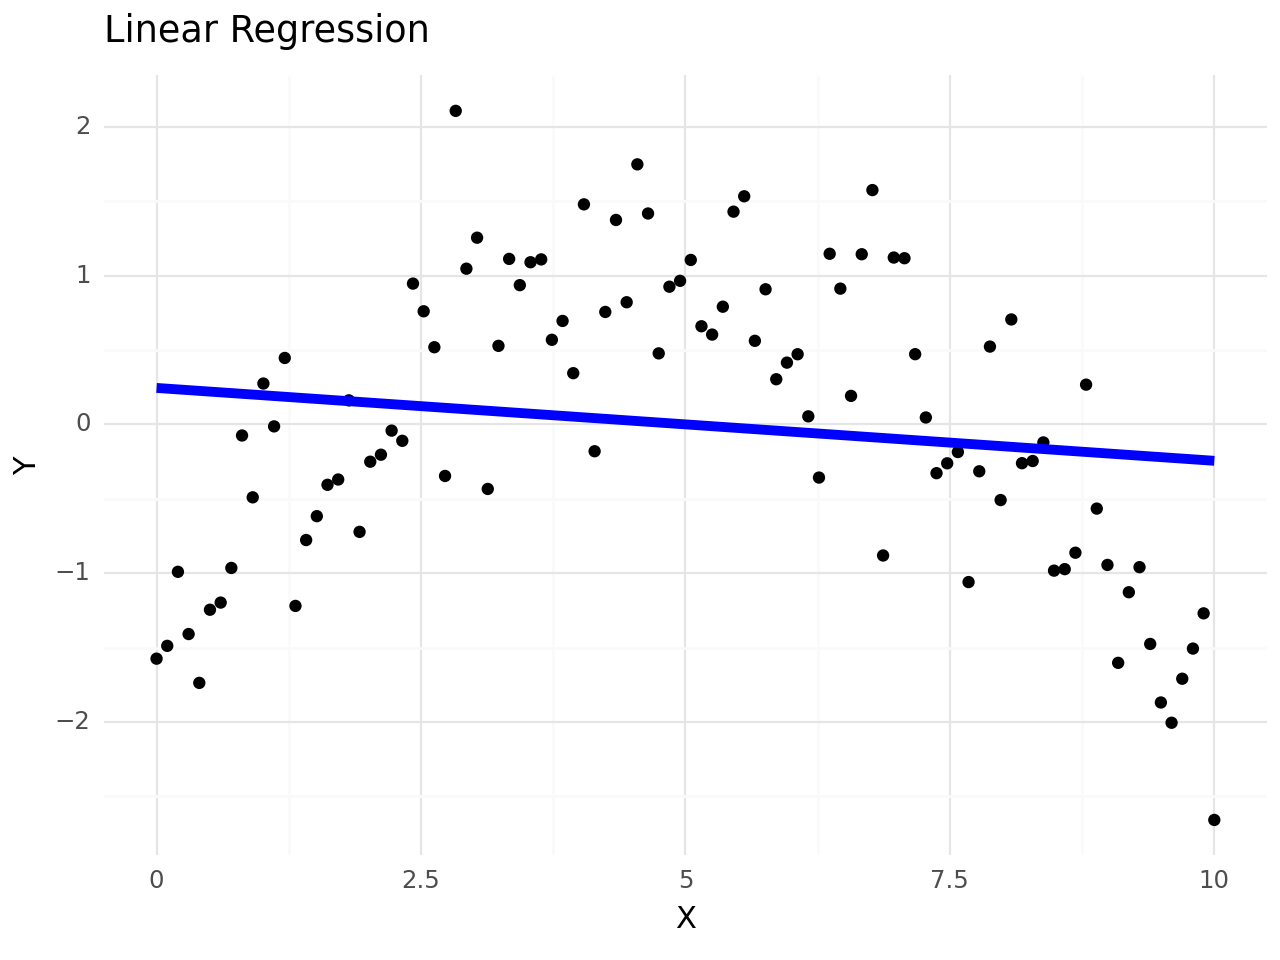

<Figure Size: (640 x 480)>

In [46]:
(ggplot(df, aes(x = "ChickenFingers", y = "Happiness")) + geom_point() + 
 labs(x = "X", y = "Y", title = "Linear Regression") +
  geom_smooth(method = "lm", se = False, color = "blue", size = 2) +
  theme_minimal())

In [47]:
# Load Data
df = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/07_cw.csv")

# drop missing values
df.dropna(inplace = True)
df.reset_index(inplace = True)

# set up X and y
predictors = ["ChickenFingers"]

X = df[predictors]
y = df["Happiness"]

# z score
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

lr = LinearRegression()

pipe = Pipeline([("zscore", z),
                ("poly", PolynomialFeatures(degree = 2)),
                ("linearregression", lr)])

# fit
pipe.fit(X,y)

# predict
y_pred = pipe.predict(X)

# assess
print("MSE : ", mean_squared_error(y, y_pred))
print("MAE : ", mean_absolute_error(y, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y, y_pred))
print("R2  : ", r2_score(y, y_pred))


MSE :  0.290353290841735
MAE :  0.4376747935901826
MAPE:  0.290353290841735
R2  :  0.706713847634611


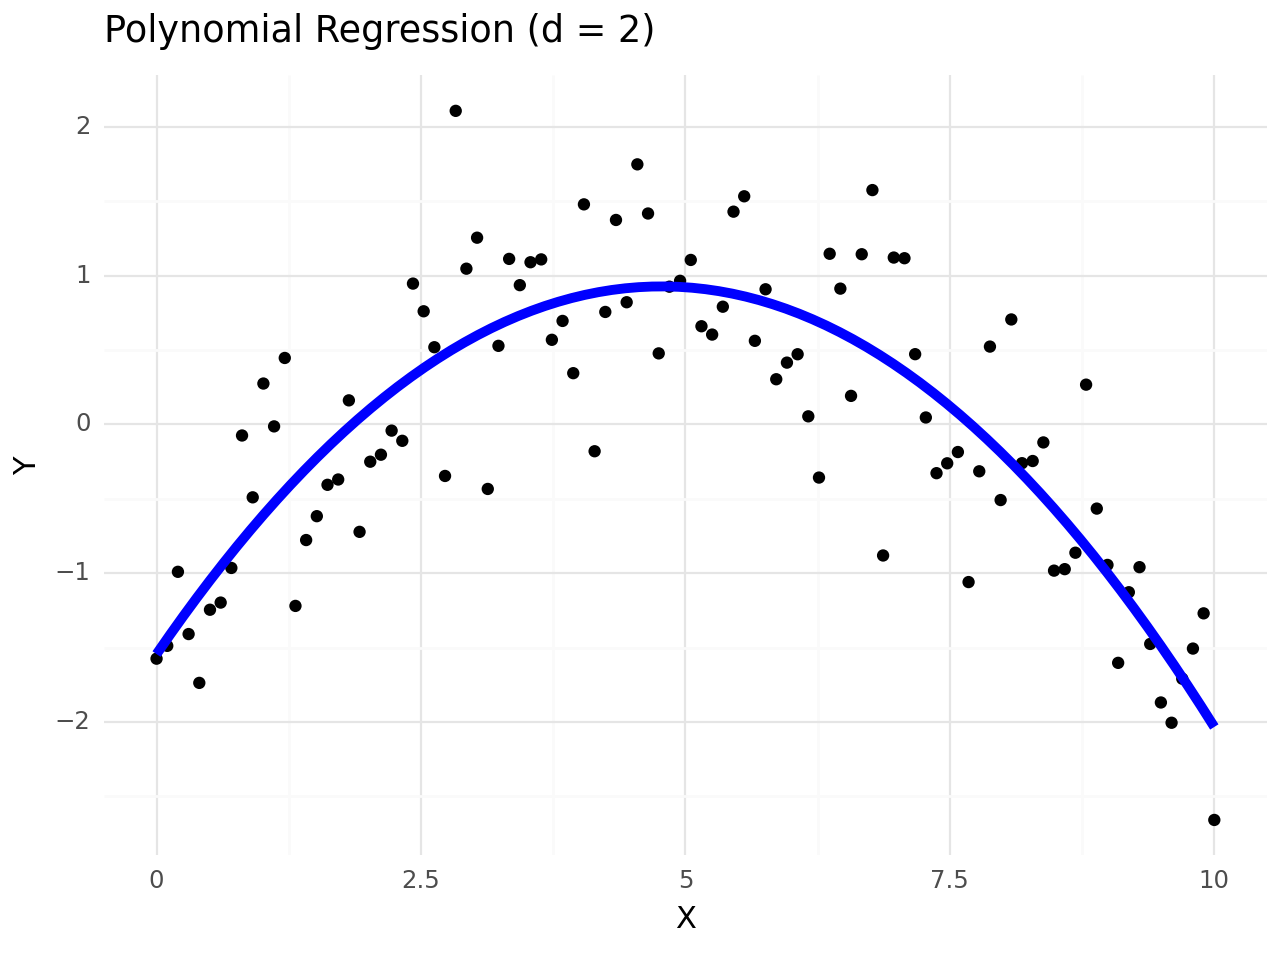

<Figure Size: (640 x 480)>

In [48]:
def poly(x, degree=1):
    """
    from: https://stackoverflow.com/questions/63344621/fit-non-linear-curve-using-plotnine
    Fit Polynomial

    These are non orthogonal factors, but it may not matter if
    we only need this for smoothing and not extrapolated
    predictions.
    """
    d = {}
    for i in range(degree+1):
        if i == 1:
            d['x'] = x
        else:
            d[f'x**{i}'] = np.power(x, i)
    return pd.DataFrame(d)

(ggplot(df, aes(x = "ChickenFingers", y = "Happiness")) + geom_point() + 
 labs(x = "X", y = "Y", title = "Polynomial Regression (d = 2)") +
  geom_smooth(method = "lm", se = False, formula = 'y ~ poly(x, degree=2)', color = "blue", size = 2) +
  theme_minimal())

Let's copy this code and make a Polynomial with `degree = 25` and see what happens.

In [50]:
#Your code here


Now that you know the power of Polynomial Regression, let's practice building some Polynomial Regression Models!

In [51]:
#### Let's use mtcars data
from plotnine.data import mtcars

In [52]:
mtcars.head(5)
#mtcars comprises 11 features of 32 automobiles from the 1974 Motor Trend US magazine. 
# mpg Miles/(US) gallon
# cyl Number of cylinders
# disp Displacement (cu.in.)
# hp Gross horsepower
# drat Rear axle ratio
# wt Weight (1000 lbs)
# qsec 1/4 mile time
# vs Engine (0 = V-shaped, 1 = straight)
# am Transmission (0 = automatic, 1 = manual)
# gear Number of forward gears

,name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,predicted_mpg
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,22.493696
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,20.177207
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,25.218976
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1,19.244363
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2,18.392533


In [75]:
#Plot the wt (x-axis) and mpg (y-axis) using plotnine/ggplot

In [ ]:
#Fit a LinearRegression() model to predict mpg based on wt, and print out the MSE, MAE, R2, and MAPE

# predict


# assess
print("MSE : ", mean_squared_error(y, y_pred))
print("MAE : ", mean_absolute_error(y, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y, y_pred))
print("R2  : ", r2_score(y, y_pred))

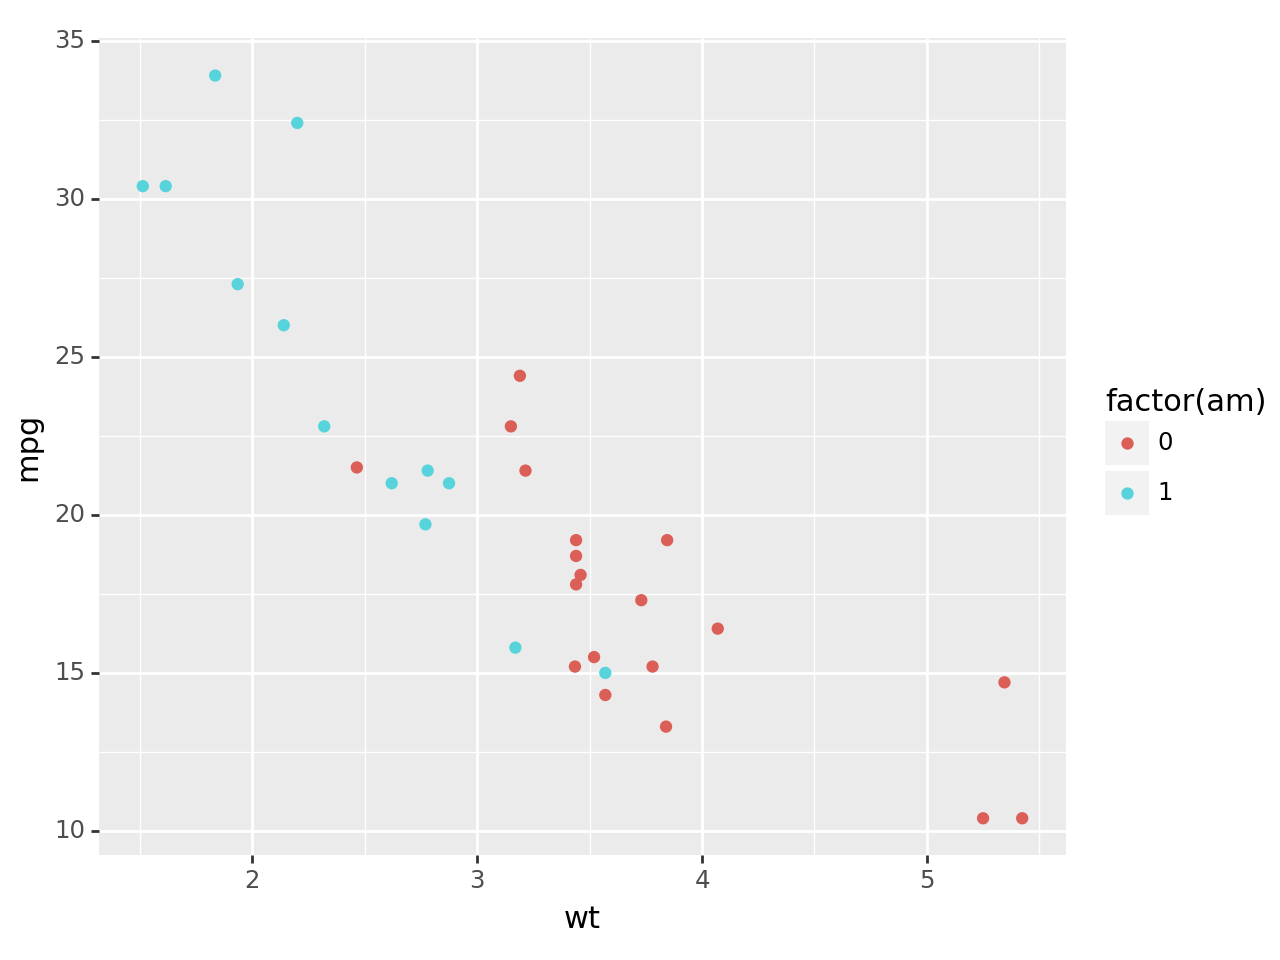

<Figure Size: (640 x 480)>

In [68]:
#Plot the wt (x-axis) and mpg (y-axis) using am as a factor
(ggplot(mtcars, aes(x = "wt", y = "mpg", color="factor(am)")) + geom_point())

In [69]:
#Now consider two features: wt and am, 
#Fit a LinearRegression() model with PolynomialFeatures(), 
#only consider interactions, and print out the MSE, MAE, R2, and MAPE


In [71]:
X = mtcars[["wt","am"]]
y = mtcars["mpg"]
poly = PolynomialFeatures(interaction_only=True,include_bias= False)
x_new = pd.DataFrame(poly.fit_transform(X))
x_new.columns = poly.get_feature_names_out(X.columns)
x_new.head()

,wt,am,wt am
0,2.620,1.0,2.620
1,2.875,1.0,2.875
2,2.320,1.0,2.320
3,3.215,0.0,0.000
4,3.440,0.0,0.000


In [ ]:
# fit x_new

# predict

# assess
print("MSE : ", mean_squared_error(y, y_pred))
print("MAE : ", mean_absolute_error(y, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y, y_pred))
print("R2  : ", r2_score(y, y_pred))

Compare the model without feature "am", what do you see based on the assessment?

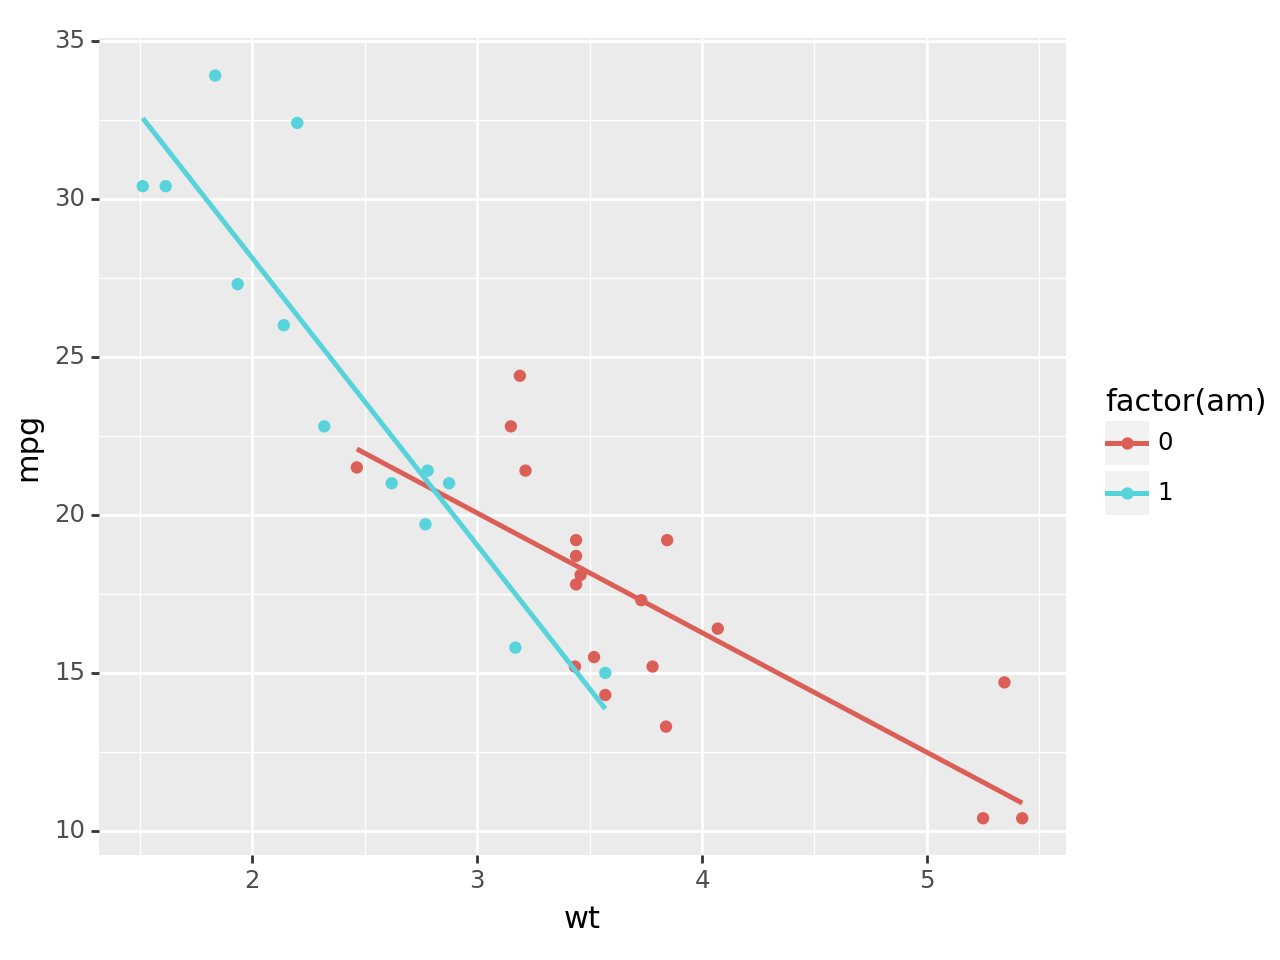

<Figure Size: (640 x 480)>

In [74]:
### plot the fitted line
mtcars['predicted_mpg']=lr.predict(x_new)
(ggplot(mtcars, aes(x = "wt", y = "mpg",color="factor(am)")) + geom_point()+geom_line(aes(y = "predicted_mpg"), size = 1))